In [1]:
## Berlin rent prediction

In [2]:
# ==============================================================================
# ABSCHNITT 1: SETUP UND KONFIGURATION
# ==============================================================================
# Zweck: Importiert alle notwendigen Bibliotheken und konfiguriert das
#        Erscheinungsbild von Plots und Tabellen für das gesamte Skript.
# ==============================================================================

# --- 1.1 Bibliotheken für Datenanalyse und Visualisierung ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# --- 1.2 Bibliotheken für Machine Learning und Modellierung ---
# Werkzeuge für Datenaufteilung und Modell-Validierung
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
# Werkzeuge für die Datenvorverarbeitung (Pipelines)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
# Verschiedene Regressionsmodelle
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# Metriken zur Bewertung der Modellleistung
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Werkzeuge zur Modellinterpretation und Analyse
import shap
from scipy.stats import randint
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings

# --- 1.3 Globale Konfigurationen für die Anzeige ---
pd.set_option('display.max_columns', 20)
sns.set(style='whitegrid', palette='muted', font_scale=0.9)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['figure.figsize'] = (8, 5)

print("✅ Abschnitt 1: Setup und Konfiguration abgeschlossen.")

✅ Abschnitt 1: Setup und Konfiguration abgeschlossen.


✅ Datensatz mit 268850 Zeilen und 49 Spalten geladen.
✅ Auf 10406 Einträge für Berlin gefiltert.

📈 --- Start der explorativen Datenanalyse ---


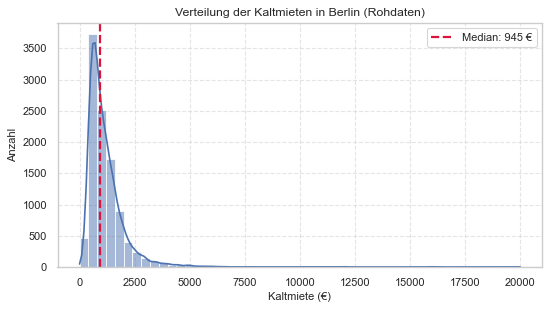

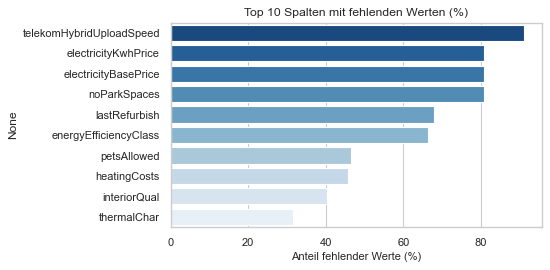

✅ Abschnitt 2: Daten laden und EDA abgeschlossen.


In [3]:
# ==============================================================================
# ABSCHNITT 2: DATEN LADEN UND EXPLORATIVE ANALYSE (EDA)
# ==============================================================================
# Zweck: Lädt den Rohdatensatz, filtert ihn auf Berlin und führt eine erste
#        visuelle Untersuchung durch, um die Daten zu verstehen.
# ==============================================================================

# --- 2.1 Daten aus CSV-Datei laden ---
try:
    df_raw = pd.read_csv('data/immo_data.csv')
    print(f"✅ Datensatz mit {df_raw.shape[0]} Zeilen und {df_raw.shape[1]} Spalten geladen.")
except FileNotFoundError:
    print("❌ Fehler: 'immo_data.csv' nicht gefunden. Stelle sicher, dass die Datei im Ordner 'data/' liegt.")
    exit()

# --- 2.2 Datensatz auf Berlin filtern ---
berlin_df = df_raw[(df_raw['regio2'] == 'Berlin') | (df_raw['regio3'] == 'Berlin')].copy()
if berlin_df.empty:
    print("⚠️ Keine Daten für Berlin gefunden. Das Skript wird beendet.")
    exit()
else:
    print(f"✅ Auf {len(berlin_df)} Einträge für Berlin gefiltert.")

# --- 2.3 Explorative Datenanalyse (EDA) ---
print("\n📈 --- Start der explorativen Datenanalyse ---")

def plot_rent_distribution(df):
    plt.figure(figsize=(7, 4))
    sns.histplot(df['baseRent'], bins=50, kde=True, color="#4C72B0")
    plt.title('Verteilung der Kaltmieten in Berlin (Rohdaten)', fontsize=11)
    plt.xlabel('Kaltmiete (€)', fontsize=10)
    plt.ylabel('Anzahl', fontsize=10)
    plt.axvline(df['baseRent'].median(), color='crimson', ls='--', lw=2, label=f"Median: {df['baseRent'].median():.0f} €")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_rent_distribution(berlin_df)

def plot_missing_values(df):
    missing = df.isnull().mean().sort_values(ascending=False).head(10)
    if not missing.empty and missing.iloc[0] > 0:
        plt.figure(figsize=(7, 3.5))
        sns.barplot(x=missing.values * 100, y=missing.index, hue=missing.index, palette="Blues_r", legend=False)
        plt.title("Top 10 Spalten mit fehlenden Werten (%)", fontsize=11)
        plt.xlabel("Anteil fehlender Werte (%)", fontsize=10)
        plt.tight_layout()
        plt.show()
    else:
        print("✅ Keine signifikanten fehlenden Werte in den Top 10 Spalten.")

plot_missing_values(berlin_df)

print("✅ Abschnitt 2: Daten laden und EDA abgeschlossen.")

In [4]:
# ==============================================================================
# ABSCHNITT 3: FEATURE ENGINEERING UND DATENBEREINIGUNG
# ==============================================================================
# Zweck: Umwandlung der Rohdaten in ein sauberes, für das Modellieren
#        geeignetes Format durch Erstellen und Bereinigen von Features.
# ==============================================================================

print("\n🛠️ --- Start Feature Engineering & Datenbereinigung ---")

def engineer_features(df):
    initial_cols = [
        'livingSpace', 'balcony', 'hasKitchen', 'condition', 'interiorQual',
        'lift', 'yearConstructed', 'garden', 'postalCode', 'baseRent', 'totalRent', 'serviceCharge'
    ]
    df_engineered = df[[col for col in initial_cols if col in df.columns]].copy()

    leakage_vars = ['totalRent', 'serviceCharge']
    df_engineered.drop(columns=[col for col in leakage_vars if col in df_engineered.columns], inplace=True, errors='ignore')
    print(f"✅ Leakage-Variablen wurden entfernt.")

    if 'yearConstructed' in df_engineered.columns:
        df_engineered['age'] = 2025 - df_engineered['yearConstructed']
    if 'age' in df_engineered.columns:
        df_engineered['isNew'] = (df_engineered['age'] <= 5).astype(bool)

    if 'postalCode' in df_engineered.columns:
        # STRATEGIE 1: Fehlende PLZ mit Platzhalter füllen
        plz_str = df_engineered['postalCode'].fillna('00000').astype(str)
        
        plz_prefix = pd.to_numeric(plz_str.str[:2], errors='coerce').fillna(0)
        df_engineered['isEastBerlin'] = plz_prefix.apply(lambda x: True if 10 <= x <= 13 else False).astype(bool)
        
        plz_to_bezirk = {
            '10115': 'Mitte', '10117': 'Mitte', '10119': 'Mitte', '10178': 'Mitte',
            '10243': 'Friedrichshain-Kreuzberg', '10245': 'Friedrichshain-Kreuzberg',
            '10247': 'Friedrichshain-Kreuzberg', '10249': 'Friedrichshain-Kreuzberg',
            '10315': 'Lichtenberg', '10317': 'Lichtenberg', '10318': 'Treptow-Köpenick',
            '10319': 'Lichtenberg', '10365': 'Lichtenberg', '10367': 'Lichtenberg', '10369': 'Lichtenberg',
            '10405': 'Pankow', '10407': 'Pankow', '10409': 'Pankow',
            '10435': 'Pankow', '10437': 'Pankow', '10439': 'Pankow',
            '10551': 'Mitte', '10553': 'Charlottenburg-Wilmersdorf', '10555': 'Mitte',
            '10557': 'Mitte', '10559': 'Mitte', '10585': 'Charlottenburg-Wilmersdorf',
            '10587': 'Charlottenburg-Wilmersdorf', '10589': 'Charlottenburg-Wilmersdorf',
            '10623': 'Charlottenburg-Wilmersdorf', '10625': 'Charlottenburg-Wilmersdorf',
            '10627': 'Charlottenburg-Wilmersdorf', '10629': 'Charlottenburg-Wilmersdorf',
            '10707': 'Charlottenburg-Wilmersdorf', '10709': 'Charlottenburg-Wilmersdorf',
            '10711': 'Charlottenburg-Wilmersdorf', '10713': 'Charlottenburg-Wilmersdorf',
            '10715': 'Charlottenburg-Wilmersdorf', '10717': 'Charlottenburg-Wilmersdorf',
            '10719': 'Charlottenburg-Wilmersdorf', '10777': 'Tempelhof-Schöneberg',
            '10779': 'Tempelhof-Schöneberg', '10781': 'Tempelhof-Schöneberg',
            '10783': 'Tempelhof-Schöneberg', '10785': 'Mitte', '10787': 'Mitte',
            '10789': 'Charlottenburg-Wilmersdorf', '10823': 'Tempelhof-Schöneberg',
            '10825': 'Tempelhof-Schöneberg', '10827': 'Tempelhof-Schöneberg',
            '10829': 'Tempelhof-Schöneberg', '10961': 'Friedrichshain-Kreuzberg',
            '10963': 'Friedrichshain-Kreuzberg', '10965': 'Friedrichshain-Kreuzberg',
            '10967': 'Friedrichshain-Kreuzberg', '10969': 'Friedrichshain-Kreuzberg',
            '10997': 'Friedrichshain-Kreuzberg', '10999': 'Friedrichshain-Kreuzberg'
        }
        df_engineered['bezirk'] = plz_str.map(plz_to_bezirk)
    
    df_engineered.drop(columns=['yearConstructed', 'postalCode'], inplace=True, errors='ignore')
    df_clean = df_engineered.copy()

    def remove_outliers_iqr(df, column):
        if column in df.columns:
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        return df

    df_clean = remove_outliers_iqr(df_clean, 'baseRent')
    df_clean = remove_outliers_iqr(df_clean, 'livingSpace')
    print(f"✅ Daten nach Ausreißer-Entfernung: {df_clean.shape[0]} Zeilen.")

    if 'baseRent' in df_clean.columns:
        df_clean.dropna(subset=['baseRent'], inplace=True)
    
    return df_clean

df_model = engineer_features(berlin_df)
print("✅ Abschnitt 3: Feature Engineering abgeschlossen.")
df_model.info()



🛠️ --- Start Feature Engineering & Datenbereinigung ---
✅ Leakage-Variablen wurden entfernt.
✅ Daten nach Ausreißer-Entfernung: 9581 Zeilen.
✅ Abschnitt 3: Feature Engineering abgeschlossen.
<class 'pandas.core.frame.DataFrame'>
Index: 9581 entries, 45 to 268829
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   livingSpace   9581 non-null   float64
 1   balcony       9581 non-null   bool   
 2   hasKitchen    9581 non-null   bool   
 3   condition     7446 non-null   object 
 4   interiorQual  5606 non-null   object 
 5   lift          9581 non-null   bool   
 6   garden        9581 non-null   bool   
 7   baseRent      9581 non-null   float64
 8   age           8234 non-null   float64
 9   isNew         9581 non-null   bool   
dtypes: bool(5), float64(3), object(2)
memory usage: 495.9+ KB



🔬 --- Analyse der aufbereiteten Daten ---

📊 Korrelationsmatrix der numerischen Features:


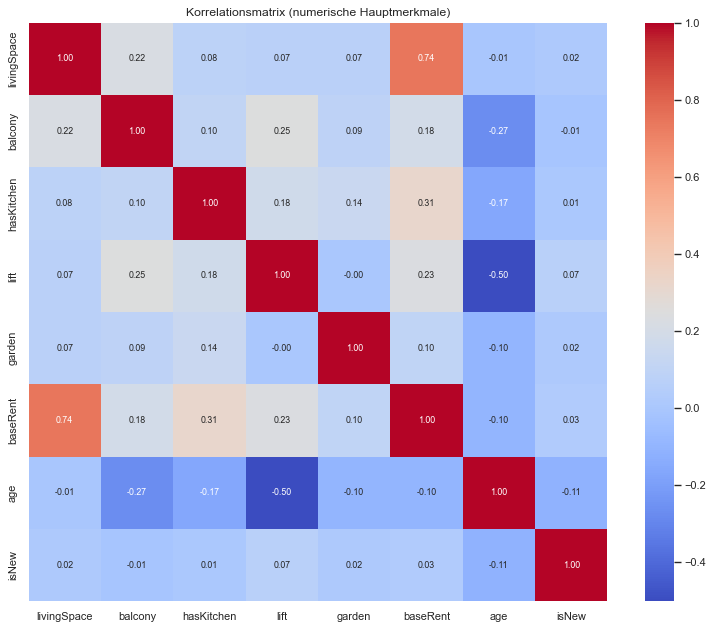


🔍 Variance Inflation Factor (VIF):
       Feature       VIF
0  livingSpace  6.322410
1      balcony  3.789630
5          age  2.403193
3         lift  2.295063
2   hasKitchen  2.287698
4       garden  1.193233
6        isNew  1.022338

✅ Zielvariable 'baseRent' wurde für das Modelltraining log-transformiert.
✅ Abschnitt 4: Daten-Analyse vor dem Training abgeschlossen.


In [5]:
# ==============================================================================
# ABSCHNITT 4: DATEN-ANALYSE VOR DEM TRAINING
# ==============================================================================
# Zweck: Untersuchung der aufbereiteten Daten auf Korrelationen und
#        Multikollinearität, bevor sie in die Pipeline gehen.
# ==============================================================================

print("\n🔬 --- Analyse der aufbereiteten Daten ---")

# --- 4.1 Korrelationsmatrix der numerischen Features ---
print("\n📊 Korrelationsmatrix der numerischen Features:")
numerical_features_for_corr = df_model.select_dtypes(include=[np.number, 'bool']).columns.tolist()
corr = df_model[numerical_features_for_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', square=True, annot_kws={"size": 8})
plt.title('Korrelationsmatrix (numerische Hauptmerkmale)', fontsize=11)
plt.tight_layout()
plt.show()

# --- 4.2 Prüfung auf Multikollinearität mit VIF ---
print("\n🔍 Variance Inflation Factor (VIF):")
X_vif = df_model.select_dtypes(include=[np.number, 'bool']).drop(columns=['baseRent'], errors='ignore')
X_vif.dropna(inplace=True)
X_vif = X_vif.astype(int)

if not X_vif.empty and len(X_vif.columns) > 1:
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    print(vif_data.sort_values(by="VIF", ascending=False))
else:
    print("Nicht genügend numerische Features für die VIF-Analyse gefunden.")

# --- 4.3 Log-Transformation der Zielvariable ---
df_model['baseRent'] = np.log1p(df_model['baseRent'])
print("\n✅ Zielvariable 'baseRent' wurde für das Modelltraining log-transformiert.")

print("✅ Abschnitt 4: Daten-Analyse vor dem Training abgeschlossen.")

In [6]:
# ==============================================================================
# ABSCHNITT 5: DEFINITION DER VORVERARBEITUNGS-PIPELINE
# ==============================================================================
# Zweck: Kapselung aller Vorverarbeitungsschritte in einer robusten Pipeline.
# ==============================================================================

print("\n⚙️ --- Definition der Vorverarbeitungs-Pipeline ---")

X = df_model.drop('baseRent', axis=1)
y = df_model['baseRent']

numeric_features = X.select_dtypes(include=[np.number, 'bool']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Gefundene numerische/boolesche Features: {len(numeric_features)}")
print(f"Gefundene kategoriale Features: {len(categorical_features)}")

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)
print("✅ Abschnitt 5: Vorverarbeitungs-Pipeline definiert.")


⚙️ --- Definition der Vorverarbeitungs-Pipeline ---
Gefundene numerische/boolesche Features: 7
Gefundene kategoriale Features: 2
✅ Abschnitt 5: Vorverarbeitungs-Pipeline definiert.


In [7]:
# ==============================================================================
# ABSCHNITT 6: MODELLVERGLEICH MIT KREUZVALIDIERUNG
# ==============================================================================
# Zweck: Systematischer Vergleich verschiedener Regressionsmodelle.
# ==============================================================================

print("\n🔄 --- Start des Modellvergleichs ---")

models_to_compare = {
    "Lineare Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "LightGBM": LGBMRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "MLP Regressor": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

results = []
for name, model in models_to_compare.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2', n_jobs=-1)
    
    results.append({
        'Modell': name,
        'R² (Durchschnitt)': round(cv_scores.mean(), 4),
        'R² (Std. Abw.)': round(cv_scores.std(), 4)
    })
    print(f"✓ {name} evaluiert.")

results_df = pd.DataFrame(results).sort_values(by='R² (Durchschnitt)', ascending=False)
print("\n📊 Ergebnisse des Modellvergleichs (5-fache Kreuzvalidierung):")
display(results_df.style.background_gradient(cmap='summer_r', subset=['R² (Durchschnitt)']))

print("✅ Abschnitt 6: Modellvergleich abgeschlossen.")


🔄 --- Start des Modellvergleichs ---
✓ Lineare Regression evaluiert.
✓ Ridge evaluiert.
✓ Lasso evaluiert.
✓ Decision Tree evaluiert.
✓ Random Forest evaluiert.
✓ LightGBM evaluiert.
✓ XGBoost evaluiert.
✓ MLP Regressor evaluiert.

📊 Ergebnisse des Modellvergleichs (5-fache Kreuzvalidierung):


,Modell,R² (Durchschnitt),R² (Std. Abw.)
5,LightGBM,0.763600,0.021400
6,XGBoost,0.742200,0.034800
4,Random Forest,0.734500,0.026500
7,MLP Regressor,0.715900,0.019300
0,Lineare Regression,0.678000,0.019600
1,Ridge,0.678000,0.019500
3,Decision Tree,0.663100,0.042000
2,Lasso,0.532100,0.018600


✅ Abschnitt 6: Modellvergleich abgeschlossen.


In [8]:
# ==============================================================================
# ABSCHNITT 7: HYPERPARAMETER-TUNING DES BESTEN MODELLS
# ==============================================================================
# Zweck: Optimierung des leistungsstärksten Modells aus dem Vergleich.
# ==============================================================================

print("\n⚙️ --- Start Hyperparameter-Tuning für das beste Modell (LightGBM) ---")

final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(random_state=42, n_jobs=-1))
])

param_dist = {
    'regressor__n_estimators': randint(100, 700),
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__num_leaves': randint(20, 50),
    'regressor__subsample': [0.7, 0.8, 0.9, 1.0],
    'regressor__colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
random_search = RandomizedSearchCV(
    final_pipeline,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    verbose=1,
    n_jobs=-1
)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    random_search.fit(X_train, y_train)

best_model_pipeline = random_search.best_estimator_
print("\n✅ Besten Parameter für LightGBM gefunden:", random_search.best_params_)

y_pred_log = best_model_pipeline.predict(X_test)
y_pred_original = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)

mae_final = mean_absolute_error(y_test_original, y_pred_original)
rmse_final = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2_final = r2_score(y_test_original, y_pred_original)

print(f"\n🎯 Leistung des finalen, getunten LightGBM-Modells auf Testdaten:")
print(f"   -> MAE (Durchschnittlicher Fehler): {mae_final:.2f} €")
print(f"   -> RMSE (Wurzel des mittl. quadr. Fehlers): {rmse_final:.2f} €")
print(f"   -> R² (Bestimmtheitsmaß): {r2_final:.2f}")

print("✅ Abschnitt 7: Hyperparameter-Tuning abgeschlossen.")


⚙️ --- Start Hyperparameter-Tuning für das beste Modell (LightGBM) ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 432
[LightGBM] [Info] Number of data points in the train set: 7664, number of used features: 18
[LightGBM] [Info] Start training from score 6.788757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

✅ Besten Parameter für LightGBM gefunden: {'regressor__colsample_bytree': 0.7, 'regressor__learning_rate': 0.01, 'regressor__n_estimators': 574, 'regressor__num_leaves': 46, 'regressor__subsample': 0.9}

🎯 Leistung des finalen, getunten LightGBM-Modells auf Testdaten:
   -> MAE (Durchschnittlicher Fehler): 162.15 €
   -> RMSE (Wurzel des mittl. quadr. Fehlers): 222.91 €
   -> R² (Best

/Users/adnansalem/Github/berlin_rent_prediction/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



🔬 --- Start der finalen Modellanalyse ---


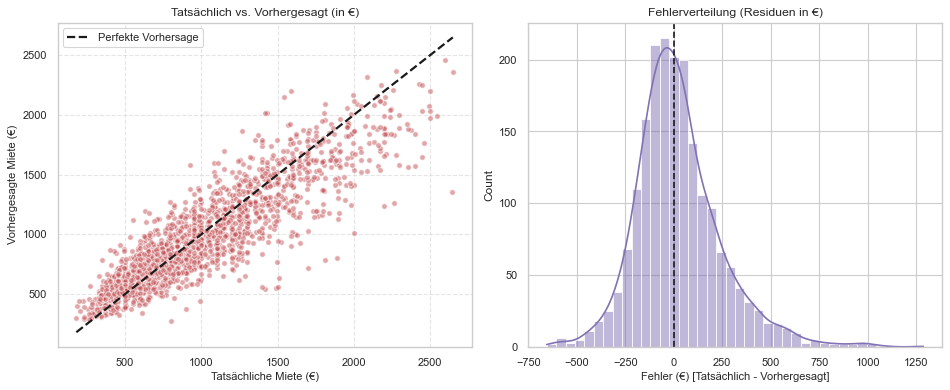


🧠 --- Berechnung der SHAP Feature Importance ---
SHAP Summary Plot (zeigt die wichtigsten Einflussfaktoren auf die Miete):


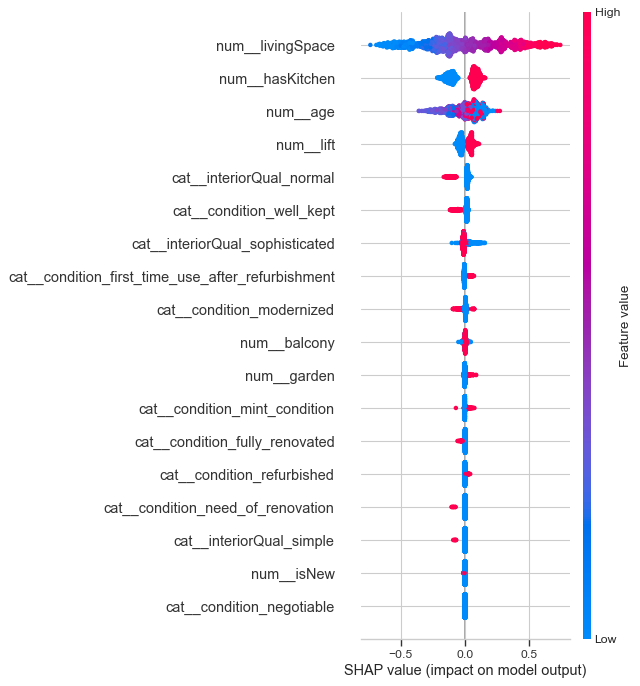


🎉 --- Analyse abgeschlossen --- 🎉


In [9]:
# ==============================================================================
# ABSCHNITT 8: ANALYSE UND INTERPRETATION DES FINALEN MODELLS
# ==============================================================================
# Zweck: Untersuchung der Modellvorhersagen und Interpretation der wichtigsten
#        Einflussfaktoren auf den Mietpreis mit SHAP.
# ==============================================================================

print("\n🔬 --- Start der finalen Modellanalyse ---")

def plot_error_analysis(y_true, y_pred):
    errors = y_true - y_pred
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].scatter(y_true, y_pred, alpha=0.5, edgecolors='w', color='#C44E52', s=25)
    axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2, label='Perfekte Vorhersage')
    axes[0].set_title('Tatsächlich vs. Vorhergesagt (in €)', fontsize=11)
    axes[0].set_xlabel('Tatsächliche Miete (€)', fontsize=10)
    axes[0].set_ylabel('Vorhergesagte Miete (€)', fontsize=10)
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.5)
    sns.histplot(errors, bins=40, kde=True, color='#8172B3', ax=axes[1])
    axes[1].axvline(0, color='k', linestyle='--')
    axes[1].set_title('Fehlerverteilung (Residuen in €)', fontsize=11)
    axes[1].set_xlabel('Fehler (€) [Tatsächlich - Vorhergesagt]', fontsize=10)
    plt.tight_layout()
    plt.show()

plot_error_analysis(y_test_original, y_pred_original)

print("\n🧠 --- Berechnung der SHAP Feature Importance ---")

regressor = best_model_pipeline.named_steps['regressor']
preprocessor_fitted = best_model_pipeline.named_steps['preprocessor']
X_test_transformed = preprocessor_fitted.transform(X_test)
feature_names = preprocessor_fitted.get_feature_names_out()
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X_test_transformed_df)

print("SHAP Summary Plot (zeigt die wichtigsten Einflussfaktoren auf die Miete):")
shap.summary_plot(shap_values, X_test_transformed_df, plot_type="dot")

print("\n🎉 --- Analyse abgeschlossen --- 🎉")

